In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

2023-06-02 22:27:27.713069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [5]:
747/4825

0.15481865284974095

In [6]:
## **15% spam emails, 85% ham emails: This indicates class imbalance**

df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [11]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3409,spam,Do you want a New Nokia 3510i colour phone Del...,1
1657,ham,Yes I posted a couple of pics on fb. There's s...,0
4183,spam,Urgent! Please call 0906346330. Your ABTA comp...,1
5113,ham,U definitely need a module from e humanities d...,0
2039,ham,Hey are we going for the lo lesson or gym?,0


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])
# sstratify is used to make sure that there are approx equal samples of both spam and ham

In [13]:
X_train.head(4)

2521    Misplaced your number and was sending texts to...
41      Did I forget to tell you ? I want you , I need...
3176    UR GOING 2 BAHAMAS! CallFREEFONE 08081560665 a...
5189    ree entry in 2 a weekly comp for a chance to w...
Name: Message, dtype: object

In [16]:
# Now lets import BERT model and get embeding vectors for few sample statements

preprocessor_path = "/Users/jainilrana/Desktop/`/ML:DL/notebooks/DL/bert_en_uncased_preprocess_3"
encoder_path = "/Users/jainilrana/Desktop/`/ML:DL/notebooks/DL/4"

bert_preprocess = hub.KerasLayer(preprocessor_path)
bert_encoder = hub.KerasLayer(encoder_path)

2023-06-02 22:32:44.634570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-02 22:32:44.635254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-02 22:32:44.635454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-02 22:32:44.636001: I tensorflow/core/

In [17]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.88845724, ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444668 , ..., -0.85847515,
        -0.7174535 ,  0.88082975]], dtype=float32)>

In [18]:
# Get embeding vectors for few sample words. Compare them using cosine similarity

e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]]) # based on the angle of the pointer

array([[0.9911088]], dtype=float32)

In [20]:
# Values near to 1 means they are similar. 0 means they are very different.
# Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [21]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

In [22]:
# Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [23]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872034]], dtype=float32)

In [24]:
# Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

In [ ]:
"""
There are two types of models you can build in tensorflow. 

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. 
More info on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057
"""

In [25]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) # param is input
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l) # functional style, pass from previous model

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

2023-06-02 22:35:14.721731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-06-02 22:35:14.754192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-06-02 22:35:14.979612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [?,128]
	 [[{{node inputs_1}}]]
2023-06-

In [26]:
# https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [28]:
len(X_train)

1120

In [29]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [30]:
model.fit(X_train, y_train, epochs=1)

2023-06-02 22:36:12.342188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_3}}]]
2023-06-02 22:36:12.342308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_4}}]]
2023

2023-06-02 22:36:17.235931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-06-02 22:36:17.236052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-06-02 22:36:17.236153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) 

2023-06-02 22:36:19.224228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-06-02 22:36:19.224348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-06-02 22:36:19.224449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) 

35/35 [==============================] - 491s 13s/step - loss: 0.6456 - accuracy: 0.6304 - precision: 0.6294 - recall: 0.6339


In [31]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 155s 13s/step - loss: 0.5425 - accuracy: 0.8636 - precision: 0.8908 - recall: 0.8289


[0.5424671173095703,
 0.8636363744735718,
 0.8908045887947083,
 0.8288770318031311]

In [32]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten() # 2D to 1D

12/12 [==============================] - 160s 13s/step


In [33]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0) # because y_pred is a signoid value so we convert it to 0 or 1
y_predicted

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[168,  19],
       [ 32, 155]])

Text(50.722222222222214, 0.5, 'Truth')

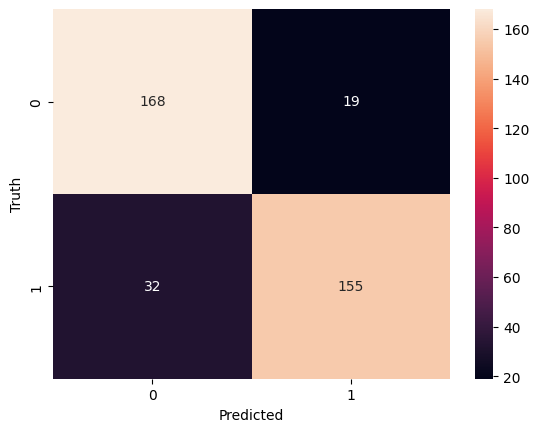

In [35]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [36]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       187
           1       0.89      0.83      0.86       187

    accuracy                           0.86       374
   macro avg       0.87      0.86      0.86       374
weighted avg       0.87      0.86      0.86       374



In [37]:
# Inference

reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

2023-06-02 22:50:12.661892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


1/1 [==============================] - 4s 4s/step


array([[0.60319686],
       [0.52704644],
       [0.6015271 ],
       [0.42300108],
       [0.3456678 ]], dtype=float32)